# Initiating the environment

Before any SARIMA model can be implemented, the python environment needs to be initialized. This is done by importing the relevant packages and setting some global variables.

In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm
from sklearn import metrics


In [8]:
machine = "local"

if machine == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    save_dir = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/' # used for storing the trained model
elif machine == "local":
    pred_var_path = './data_files/' # For retrieving the set of aggregated scaling vectors

    save_dir = pers_file_dir = './trained_models/' # used for storing the trained model

In [9]:

# Drop all non-relevant variables from the used dataset
with xr.open_dataset(pred_var_path + 'vars_per_eco_monthly_anomaly.nc') as ds:
    complete_ds = ds.drop_vars(['regions', 'grid_cell_weight', 'grid_cell_area', 'TER', 'monthly_flux', 'smoothed_flux', 'opt_flux',
                    'prior_flux_per_s', 'scaling_factor', 'monthly_sf', 'smoothed_sf', 'eco_area', 'ci_AVG'])

# Select to group of largest ecoregions to check from trends. These ecoregions are the region with the highest interest as these ecoregions have the largest effect on the combined flux space. For the current analysis, all ecoregions which cover more than 10% of the surface of their respective TransCom region are selected
large_eco_regions = [1.0, 7.0, 9.0, 19.0, 20.0, 23.0, 33.0, 191.0, 200.0, 204.0, 209.0]

pruned_ds = complete_ds.where(complete_ds.eco_regions.isin(large_eco_regions), drop=True)

print(pruned_ds)

# before moving forward, some data is put aside to be used for model validation later. Going for the classical 80-20% split
train_ds = pruned_ds.loc[dict(time=slice("2000-01-01","2017-01-01"))]
test_ds = pruned_ds.loc[dict(time=slice("2017-01-01","2021-01-01"))]

# Split the variables in their parameter and aggregation method
vars = ['']*36
aggr = ['']*36
for i, var in enumerate(list(test_ds.drop('sf_per_eco').data_vars)):
    print(var.split('_'))
    vars[i], aggr[i] = str(var).split('_')

<xarray.Dataset>
Dimensions:      (eco_regions: 11, time: 1096, lon: 360, lat: 180)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon          (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * eco_regions  (eco_regions) float64 1.0 7.0 9.0 19.0 ... 200.0 204.0 209.0
Data variables: (12/37)
    sf_per_eco   (eco_regions, time) float32 0.2209 0.7194 ... 0.8827 0.9176
    g10m_MAX     (eco_regions, time) float64 0.0 0.3509 -0.7395 ... -3.116 2.939
    swvl1_MIN    (eco_regions, time) float64 0.0 -0.0001536 ... 0.00195
    swvl1_MAX    (eco_regions, time) float64 0.0 -0.002324 ... 0.002162
    slhf_MIN     (eco_regions, time) float64 0.0 -4.385 6.693 ... 47.35 -25.49
    slhf_MAX     (eco_regions, time) float64 0.0 -2.097 -1.597 ... 10.18 -18.84
    ...           ...
    cp_SUM       (eco_regions, time) float64 0.0 -5.374e-08 ... 2.69e-06
    sd_MI

# Finding the hyper-parameters

While literature suggests that the monthly temperature anomaly is one of the main drivers behind the scaling factor (see Chapter 7 of the accompanying thesis), it is desirable to verify that this relation is also reflected within the data.

Note that there is no reason to change the hyperparameters used for the SARIMA implementation. Therefore, the same ARIMA(2,0,2)(1,0,1)<sub>52</sub> model is used, where the only difference is that the SARIMAX model also includes a coefficient for the used exogenous variable. This means that the SARIMAX model can only utilize linear relationships. Therefore, Pearson's correlation coefficient is used to check whether a parameter could be used as a predictor variable for the SARIMAX model.

## Checking the monhly temperature anomaly

Before checking the other variables, lets first have a closer look at the distribution of the monthly temperature anomalies and the effective scaling factor. Ideally, there is a linear trend between these two variables.

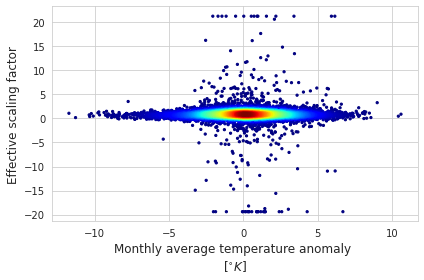

In [10]:
from scipy.stats import gaussian_kde


x = train_ds.t2m_AVG.values.flatten()
y = train_ds.sf_per_eco.values.flatten()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


plt.scatter(x, y, c=z, s=5, cmap='jet')
plt.xlabel('Monthly average temperature anomaly \n'r'[$^{\circ}K$]', fontsize=12)
plt.ylabel('Effective scaling factor', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/temp_anom_vs_sf.png')
plt.savefig('../figures/temp_anom_vs_sf.pdf')

The plot above shows that the sought after linear correlation does not seem te exist. It actually seems to be the case that no clear correlation exists. As such, it is unlikely that the SARIMAX model will perform better than the SARIMA model.

There might however be other variables which turn out to be more usefull. While looking for these usefull variables, we mainly look at the ecoregions with a large surface area as these regions are generally associate with larger fluxes.

In [11]:
# Create a dictionary where the key is the variable and the values are the correlation coefficients for every ecoregion
r_dict = {}

for var in train_ds.drop_vars(['sf_per_eco']).data_vars: # skip the first var because that is the actual scaling factor
    r_dict[var] = xr.corr(train_ds['sf_per_eco'], train_ds[var], dim="time")
    print(f'Pearson correlation of var {var}: {r_dict[var]}')

np.max(np.fabs(list(r_dict.values())))

Pearson correlation of var g10m_MAX: [-0.00260858 -0.01157899  0.00948854  0.01539623  0.01675444  0.01417311
  0.03687758 -0.05873305 -0.02690554  0.01569373 -0.03240946]
Pearson correlation of var swvl1_MIN: [-0.05627707  0.09852739  0.01267905  0.02032796  0.00730863  0.03073782
 -0.02914674  0.03329732  0.00610957 -0.01801661  0.0104327 ]
Pearson correlation of var swvl1_MAX: [-0.02768255  0.06956357 -0.00509532  0.01886542  0.00276463 -0.00176454
 -0.01356438  0.01423308 -0.00205299 -0.01220278  0.00671707]
Pearson correlation of var slhf_MIN: [ 0.01407425  0.06601387  0.01893451 -0.00974169  0.00100177  0.0198098
 -0.00591198  0.00738844 -0.08941079  0.03370019  0.00993647]
Pearson correlation of var slhf_MAX: [ 0.00531523 -0.09174997 -0.00799894  0.06275661 -0.05087842  0.03488875
  0.03755078 -0.04016474 -0.01159498 -0.01652414 -0.02028287]
Pearson correlation of var slhf_AVG: [-0.00872573  0.05818627  0.01258116  0.013469   -0.02066261  0.02957287
  0.00524335 -0.00640833 -0.0

0.10717396394988635

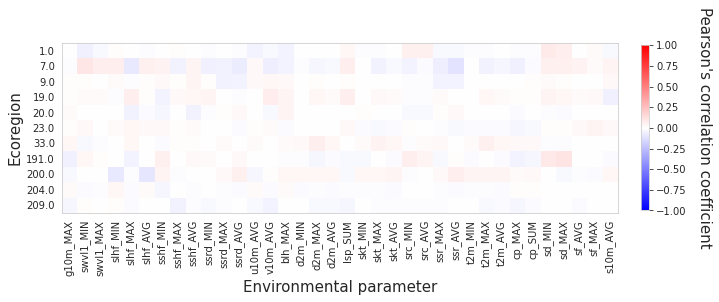

In [12]:
# make a dataframe of the dictionary of correlation coefficients
df = pd.DataFrame(data=r_dict, index=train_ds.eco_regions)

cmap = mpl.cm.get_cmap('bwr')
fig, ax = plt.subplots(figsize=(10,5))

# Set the scale from -1 to 1
im = plt.imshow(df, cmap=cmap, vmin=-1, vmax=1)
plt.grid(None)

# List the variable names
plt.yticks(np.arange(0, len(df.index), 1), df.index)
plt.ylabel('Ecoregion', fontsize=15)

# list the included ecoregions
plt.xticks(np.arange(0, len(df.columns), 1), df.columns, rotation=90)
plt.xlabel('Environmental parameter', fontsize=15)


im_ratio = df.shape[0]/df.shape[1]
cbar = plt.colorbar(im, fraction=0.046*im_ratio, pad=0.04)
cbar.set_label("Pearson's correlation coefficient", rotation=270, fontsize=15, labelpad=25)
plt.tight_layout()
plt.savefig('../figures/corr_ceoff_vars.pdf')
plt.show()


The plot above shows that very little linear correlations exist between the environmental conditions and the effective scaling factor. The highest absolute correlation coefficient is the correlation between ssr_AVG and the effective scaling factor of ecoregion 7.0, being 0.107. This can be considered a very weak correlation at best. Therefore, it is unlikely that a variable other than the monthly temperature anomaly would have resulted in a better performing SARIMAX model.